In [197]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import zscore
from scipy.stats import stats
from scipy.stats import linregress
import os
import seaborn as sns
import re
import datetime
import nbconvert
import glob
import plotly.express as px

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

ModuleNotFoundError: No module named 'plotly'

In [2]:
# Files to Load (csv files downloaded from the internet)

file1 = "data/population-density-vs-prosperity.csv"
file2 = "data/urban-and-rural-population.csv"
file3 = "data/urban-vs-rural-majority.csv"
file4 = "data/life-expectancy-at-birth-total-years.csv"
file5 = "data/median-age.csv"
file6 = "data/six-dem_mod.csv"
file7 = "data/covid-confirmed-cases-since-100th-case_hkg.csv"
file8 = "data/unsd.csv"
file9 = "data/worldometer.csv"

# Read File and store into Pandas data frame

density_vs_prosperity = pd.read_csv(file1)
urban_rural_population = pd.read_csv(file2)
urban_vs_rural_majority = pd.read_csv(file3)
life_expectancy = pd.read_csv(file4)
median_age = pd.read_csv(file5)
hoefstede = pd.read_csv(file6)
covid_data = pd.read_csv(file7, parse_dates=['Date'])
unsd = pd.read_csv(file8)
wom = pd.read_csv(file9)

In [3]:
density_vs_prosperity.shape

(47234, 6)

In [4]:
density_vs_prosperity.dropna(subset=['Code'],inplace=True)
density_vs_prosperity.shape

(44392, 6)

In [5]:
urban_rural_population.dropna(subset=['Code'],inplace=True)
urban_rural_population.shape

(12363, 5)

In [6]:
urban_vs_rural_majority.dropna(subset=['Code'],inplace=True)
urban_vs_rural_majority.shape

(24019, 5)

In [7]:
life_expectancy.dropna(subset=['Code'],inplace=True)
life_expectancy.shape

(11125, 4)

In [8]:
median_age.dropna(subset=['Code'],inplace=True)
median_age.shape

(6324, 4)

In [9]:
hoefstede.shape

(127, 8)

In [10]:
hoefstede = hoefstede.replace('#NULL!','')

In [11]:
hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']] = hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']].apply(pd.to_numeric)

In [12]:
covid_data.shape

(12768, 5)

In [13]:
unsd.shape

(250, 15)

In [14]:
unsd.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
0,1,World,142,Asia,34,Southern Asia,NaN,NaN,Afghanistan,4,AFG,x,x,NaN,Developing
1,1,World,150,Europe,154,Northern Europe,NaN,NaN,Åland Islands,248,ALA,NaN,NaN,NaN,Developed
2,1,World,150,Europe,39,Southern Europe,NaN,NaN,Albania,8,ALB,NaN,NaN,NaN,Developed
3,1,World,2,Africa,15,Northern Africa,NaN,NaN,Algeria,12,DZA,NaN,NaN,NaN,Developing
4,1,World,9,Oceania,61,Polynesia,NaN,NaN,American Samoa,16,ASM,NaN,NaN,x,Developing


In [15]:
# Merge data
merged_data = pd.merge(density_vs_prosperity, urban_rural_population, on=["Entity","Code", "Year"])
merged_data.shape

(12283, 8)

In [16]:
merged_data.head()

,Entity,Code,Year,Population density (people per km² of land area),GDP per capita (constant 2011 international $),Total population (Gapminder),Urban population,Rural population
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568
1,Afghanistan,AFG,1961,14.040934,NaN,9166764.0,796042,8370722
2,Afghanistan,AFG,1962,14.315271,NaN,9345868.0,838885,8506983
3,Afghanistan,AFG,1963,14.603367,NaN,9533954.0,884370,8649584
4,Afghanistan,AFG,1964,14.905739,NaN,9731361.0,932848,8798513


In [17]:
merged_data = pd.merge(merged_data, urban_vs_rural_majority, on=["Entity", "Code", "Year"])
merged_data.shape

(12283, 10)

In [18]:
merged_data = pd.merge(merged_data, life_expectancy, on=["Entity", "Code", "Year"])
merged_data.shape

(11007, 11)

In [19]:
merged_data = pd.merge(merged_data, unsd, on=["Code"])
merged_data.shape

(10838, 25)

In [20]:
merged_data = pd.merge(merged_data, wom, on=["Code"])
merged_data.shape

(9925, 36)

In [21]:
merged_data.head()

,Entity,Code,Year,Population density (people per km² of land area),GDP per capita (constant 2011 international $),Total population (Gapminder),Urban population,Rural population,Urban (%),Rural (%),...,totalCases,totalDeaths,totalRecovered,activeCases,criticalCases,casesMPop,deathsMPop,totalTests,testsMPop,calcPop
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568,8.401,91.598999,...,784,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000
1,Afghanistan,AFG,1961,14.040934,NaN,9166764.0,796042,8370722,8.684,91.316002,...,784,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000
2,Afghanistan,AFG,1962,14.315271,NaN,9345868.0,838885,8506983,8.976,91.024002,...,784,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000
3,Afghanistan,AFG,1963,14.603367,NaN,9533954.0,884370,8649584,9.276,90.723999,...,784,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000
4,Afghanistan,AFG,1964,14.905739,NaN,9731361.0,932848,8798513,9.586,90.414001,...,784,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000


In [22]:
merged_data = pd.merge(merged_data, median_age, on=["Entity", "Code", "Year"])
merged_data.shape

(2057, 37)

In [23]:
merged_data.head()

,Entity,Code,Year,Population density (people per km² of land area),GDP per capita (constant 2011 international $),Total population (Gapminder),Urban population,Rural population,Urban (%),Rural (%),...,totalDeaths,totalRecovered,activeCases,criticalCases,casesMPop,deathsMPop,totalTests,testsMPop,calcPop,UN Population Division (Median Age) (2017) (years)
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568,8.401,91.598999,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,18.799999
1,Afghanistan,AFG,1965,15.222887,NaN,9938414.0,984301,8954113,9.904,90.096001,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,18.400000
2,Afghanistan,AFG,1970,17.042127,NaN,11126123.0,1295415,9830708,11.643,88.357002,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.900000
3,Afghanistan,AFG,1975,19.284818,NaN,12590286.0,1717441,10872845,13.641,86.359001,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.400000
4,Afghanistan,AFG,1980,20.292819,NaN,13248370.0,2119077,11129293,15.995,84.004997,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.000000


In [24]:
merged_data.columns

Index(['Entity', 'Code', 'Year',
       'Population density (people per km² of land area)',
       'GDP per capita (constant 2011 international $)',
       'Total population (Gapminder)', 'Urban population', 'Rural population',
       'Urban (%)', 'Rural (%)',
       'Life expectancy at birth, total (years) (years)', 'Global Code',
       'Global Name', 'Region Code', 'Region Name', 'Sub-region Code',
       'Sub-region Name', 'Intermediate Region Code',
       'Intermediate Region Name', 'Country or Area', 'M49 Code',
       'Least Developed Countries (LDC)',
       'Land Locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)',
       'Developed / Developing Countries', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop',
       'UN Population Division (Median Age) (2017) (years)'],
      dtype='object')

In [25]:
#Format columns
merged_data = merged_data.rename(columns={"Population density (people per km² of land area)": "popDensity",
                                          "GDP per capita (constant 2011 international $)" : "gdp",
                                         "Total population (Gapminder)": "gapPop",
                                         "Urban population": "urbanPop",
                                         "Rural population": "ruralPop",
                                         "Urban (%)":"urbanPct",
                                         "Rural (%)": "ruralPct",
                                         "Life expectancy at birth, total (years) (years)":"lifeExpectancy",
                                         "UN Population Division (Median Age) (2017) (years)":"medianAge",
                                         "Global Code":"globalCode",
                                         "Global Name":"globalName",
                                         'Region Code':"regionCode",
                                          'Region Name':"regionName",
                                          'Sub-region Code':"subRegionCode",
                                          'Sub-region Name':"subRegionName",
                                          'Intermediate Region Code':"interRegionCode",
                                          'Intermediate Region Name':"interRegionName",
                                          'Country or Area':"country",
                                          'M49 Code':"m49",
                                          'Least Developed Countries (LDC)':"ldc",
                                          'Land Locked Developing Countries (LLDC)':"lldc",
                                          'Small Island Developing States (SIDS)':"sids",
                                          'Developed / Developing Countries':"development",
                                          'UN Population Division (Median Age) (2017) (years)_y': 'medianAge'
                                         })

In [26]:
merged_data.columns

Index(['Entity', 'Code', 'Year', 'popDensity', 'gdp', 'gapPop', 'urbanPop',
       'ruralPop', 'urbanPct', 'ruralPct', 'lifeExpectancy', 'globalCode',
       'globalName', 'regionCode', 'regionName', 'subRegionCode',
       'subRegionName', 'interRegionCode', 'interRegionName', 'country', 'm49',
       'ldc', 'lldc', 'sids', 'development', 'countryWom', 'totalCases',
       'totalDeaths', 'totalRecovered', 'activeCases', 'criticalCases',
       'casesMPop', 'deathsMPop', 'totalTests', 'testsMPop', 'calcPop',
       'medianAge'],
      dtype='object')

In [27]:
merged_data.head()

,Entity,Code,Year,popDensity,gdp,gapPop,urbanPop,ruralPop,urbanPct,ruralPct,...,totalDeaths,totalRecovered,activeCases,criticalCases,casesMPop,deathsMPop,totalTests,testsMPop,calcPop,medianAge
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568,8.401,91.598999,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,18.799999
1,Afghanistan,AFG,1965,15.222887,NaN,9938414.0,984301,8954113,9.904,90.096001,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,18.400000
2,Afghanistan,AFG,1970,17.042127,NaN,11126123.0,1295415,9830708,11.643,88.357002,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.900000
3,Afghanistan,AFG,1975,19.284818,NaN,12590286.0,1717441,10872845,13.641,86.359001,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.400000
4,Afghanistan,AFG,1980,20.292819,NaN,13248370.0,2119077,11129293,15.995,84.004997,...,25.0,43.0,716,NaN,20.0,0.6,NaN,NaN,39200000,17.000000


In [28]:
hoefstede.shape

(127, 8)

In [29]:
#hoefstede.head()

In [30]:
hoefstede = hoefstede.rename(columns={"ctr": "Code",
                                          "country" : "Entity"})
#hoefstede.head()

In [31]:
covid_data.shape

(12768, 5)

In [32]:
merged_data = pd.merge(merged_data, hoefstede, on=[ "Code"])
#merged_data.head()

In [33]:
merged_data.shape

(1358, 44)

In [34]:
merged_data['Year'].max()

2015

In [35]:
merged_data = merged_data[merged_data["Year"] == 2015]
#merged_data.head()

In [36]:
merged_data.drop(['Entity_y','Year'], axis=1,inplace=True)

In [37]:
merged_data = merged_data.rename(columns={"Entity_x": "Entity"})

In [38]:
merged_data.head()

,Entity,Code,popDensity,gdp,gapPop,urbanPop,ruralPop,urbanPct,ruralPct,lifeExpectancy,...,totalTests,testsMPop,calcPop,medianAge,pdi,idv,mas,uai,ltowvs,ivr
11,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,4558.0,1584.0,2872093,36.200001,90.0,20.0,80.0,70.0,61.0,15.0
23,Algeria,DZA,16.740504,13724.723853,39871528.0,28248180,11623348,70.848,29.152000,75.860,...,3359.0,77.0,44081633,27.500000,NaN,NaN,NaN,NaN,26.0,32.0
35,Angola,AGO,22.346439,6227.664689,27859305.0,17675615,10183690,63.446,36.554001,61.241,...,NaN,NaN,31666667,16.400000,83.0,18.0,20.0,60.0,15.0,83.0
47,Argentina,ARG,15.865065,19116.907915,43417765.0,39728558,3689207,91.503,8.497000,76.415,...,24374.0,539.0,45105263,30.799999,49.0,46.0,56.0,86.0,20.0,62.0
59,Armenia,ARM,102.456972,8195.933650,2916950.0,1840158,1076792,63.085,36.915001,74.445,...,9095.0,3069.0,2962667,33.900002,NaN,NaN,NaN,NaN,61.0,NaN


In [39]:
merged_data.shape

(114, 42)

In [40]:
#covid_data.head()

In [41]:
merged_data = pd.merge(merged_data, covid_data, on=[ "Code"])
#merged_data.head()

In [42]:
merged_data.drop(['Entity_y'], axis=1,inplace=True)

In [43]:
merged_data = merged_data.rename(columns={"Entity_x": "Entity",
                                         " (cases)" : "cases",
                                          "Number of days since the 100th confirmed case (days)":"days_gt_100"})

In [44]:
merged_data.shape

(7931, 45)

In [45]:
merged_data.tail()

,Entity,Code,popDensity,gdp,gapPop,urbanPop,ruralPop,urbanPct,ruralPct,lifeExpectancy,...,medianAge,pdi,idv,mas,uai,ltowvs,ivr,Date,cases,days_gt_100
7926,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,...,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-11,11.0,NaN
7927,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,...,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-12,14.0,NaN
7928,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,...,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-13,14.0,NaN
7929,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,...,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-14,17.0,NaN
7930,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,...,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-15,17.0,NaN


In [46]:
# Drop rows where days_gt_100 is null
#merged_data = merged_data[merged_data.days_gt_100 != 0]
merged_data.dropna(subset=['days_gt_100'],inplace=True)
merged_data.shape

(2898, 45)

In [47]:
merged_data['log_cases'] = np.log(merged_data['cases'])
merged_data['casesPop'] = (merged_data['cases']/merged_data['calcPop'])
merged_data['logcasesPop'] = np.log(merged_data['cases']/merged_data['calcPop'])
# merged_data['log_cases'] = np.log(merged_data['cases'])
# merged_data['log_cases'] = np.log(merged_data['cases'])

In [48]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 15 to 7876
Data columns (total 48 columns):
Entity             2898 non-null object
Code               2898 non-null object
popDensity         2898 non-null float64
gdp                2877 non-null float64
gapPop             2898 non-null float64
urbanPop           2898 non-null int64
ruralPop           2898 non-null int64
urbanPct           2898 non-null float64
ruralPct           2898 non-null float64
lifeExpectancy     2898 non-null float64
globalCode         2898 non-null int64
globalName         2898 non-null object
regionCode         2898 non-null int64
regionName         2898 non-null object
subRegionCode      2898 non-null int64
subRegionName      2898 non-null object
interRegionCode    506 non-null float64
interRegionName    475 non-null object
country            2898 non-null object
m49                2898 non-null int64
ldc                65 non-null object
lldc               123 non-null object
sids            

In [49]:
# Export CSV
merged_data.to_csv('merged_data_modified.csv')  

In [50]:
merged_data['Date'] = pd.to_timedelta(merged_data['Date']).dt.total_seconds().astype(int)
#merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%Y-%m-%d').dt.time

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [51]:
#merged_data.head()

## Create subset of Countries that have reached 5 days > 100 cases

In [112]:
cases5 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 5).sum())>0]

In [113]:
cases5group = cases5.groupby('Code')

In [114]:
cases5slopes = (cases5group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop5slopes = (cases5group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [115]:
merged5 = merged_data[merged_data.days_gt_100 == 5]

In [116]:
mergedcases5 = pd.merge(merged5, cases5slopes, on=["Code"])
mergedcases5 = pd.merge(mergedcases5, casesPop5slopes, on=["Code"])

In [117]:
#mergedcases5.dropna(subset=['idv'],inplace=True)

In [118]:
# Export CSV
mergedcases5.to_csv('cases5.csv')  

In [119]:
corr5 = mergedcases5.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

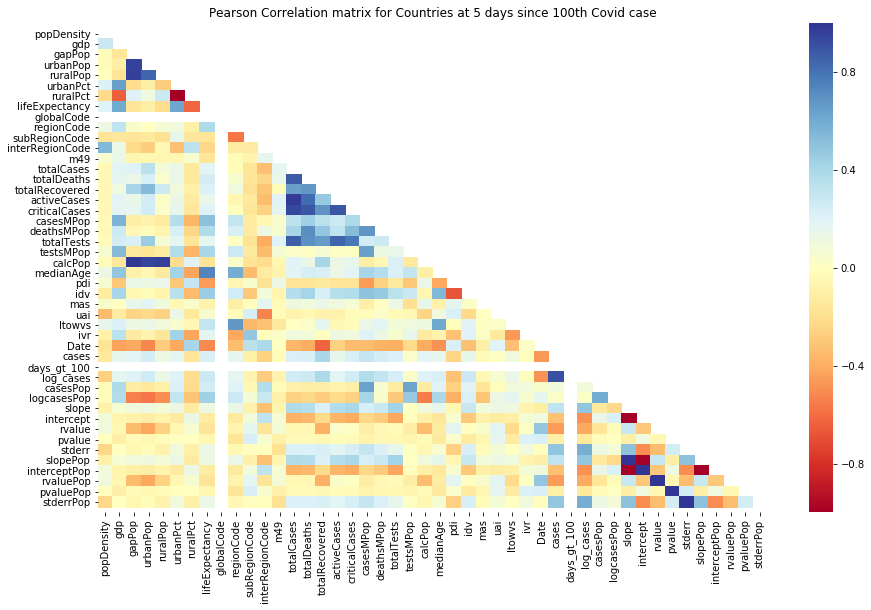

In [120]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr5)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr5,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

In [121]:
corr5.to_csv('corrcases5.csv')

## Create subset of Countries that have reached 10 days > 100 cases

In [122]:
cases10 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 10).sum())>0]

In [123]:
cases10group = cases10.groupby('Code')

In [124]:
cases10slopes = (cases10group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop10slopes = (cases10group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [125]:
merged10 = merged_data[merged_data.days_gt_100 == 10]

In [126]:
mergedcases10 = pd.merge(merged10, cases10slopes, on=["Code"])
mergedcases10 = pd.merge(mergedcases10, casesPop10slopes, on=["Code"])

In [127]:
# Export CSV
mergedcases10.to_csv('cases10.csv')  

In [128]:
corr10 = mergedcases10.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

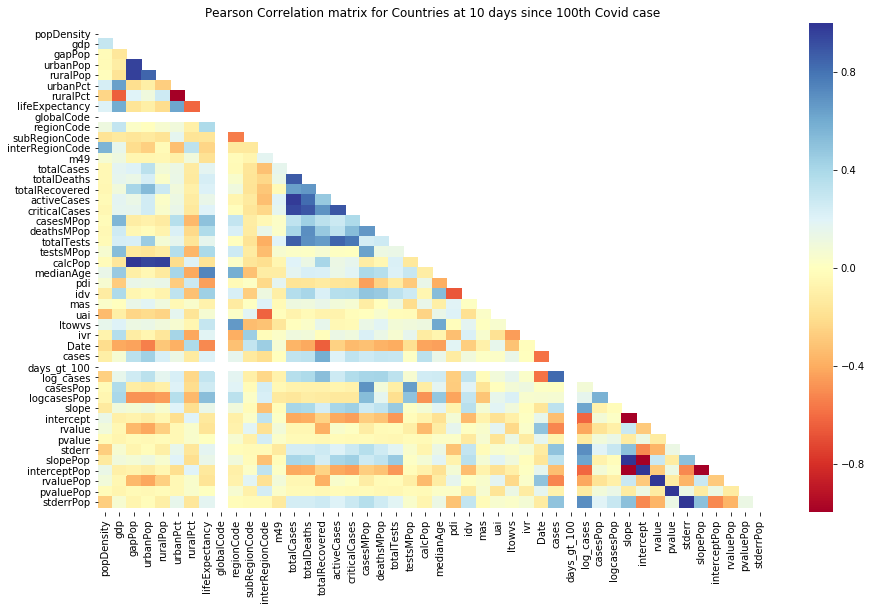

In [129]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr10)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr10,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

In [130]:
corr10.to_csv('corrcases10.csv')

## Create subset of Countries that have reached 20 days > 100 cases

In [131]:
cases20 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 20).sum())>0]

In [132]:
cases20group = cases20.groupby('Code')

In [133]:
cases20slopes = (cases20group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop20slopes = (cases20group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [134]:
merged20 = merged_data[merged_data.days_gt_100 == 20]

In [135]:
mergedcases20 = pd.merge(merged20, cases20slopes, on=["Code"])
mergedcases20 = pd.merge(mergedcases20, casesPop20slopes, on=["Code"])

In [136]:
# Export CSV
mergedcases20.to_csv('cases20.csv')  

In [137]:
corr20 = mergedcases20.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

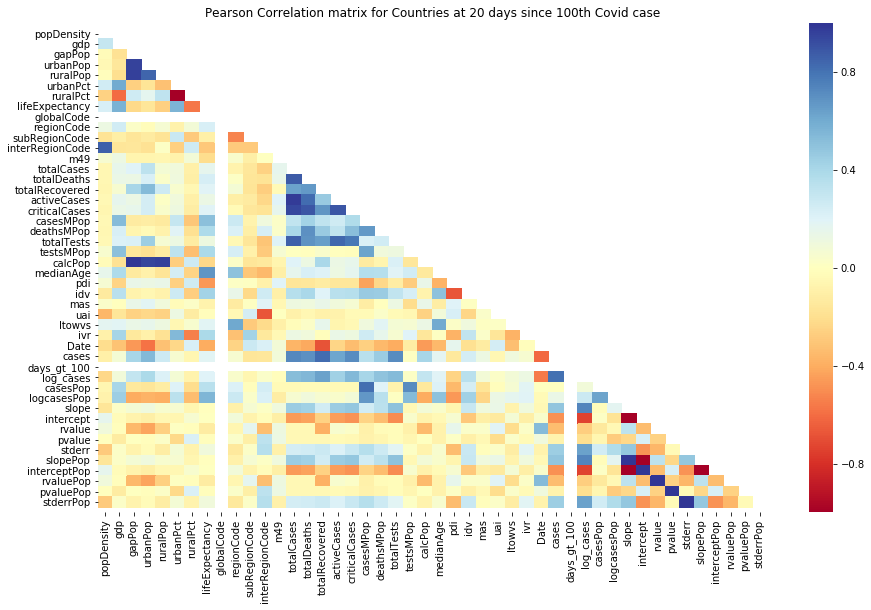

In [138]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr20)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr20,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

In [139]:
corr20.to_csv('corrcases20.csv')

## Create subset of Countries that have reached 30 days > 100 cases

In [140]:
cases30 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 30).sum())>0]

In [141]:
cases30group = cases30.groupby('Code')

In [142]:
cases30slopes = (cases30group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop30slopes = (cases30group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [143]:
merged30 = merged_data[merged_data.days_gt_100 == 30]

In [144]:
mergedcases30 = pd.merge(merged30, cases30slopes, on=["Code"])
mergedcases30 = pd.merge(mergedcases30, casesPop30slopes, on=["Code"])

In [145]:
# Export CSV
mergedcases30.to_csv('cases30.csv')  

In [146]:
corr30 = mergedcases30.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

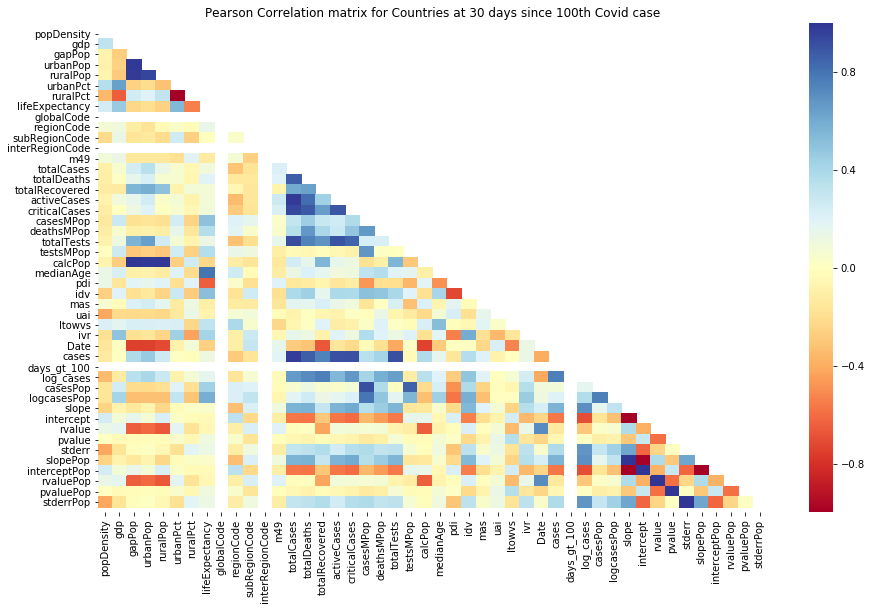

In [147]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr30)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr30,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

In [148]:
corr30.to_csv('corrcases30.csv')

## Create subset of Countries that have reached 35 days > 100 cases

In [149]:
cases35 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 35).sum())>0]

In [150]:
cases35group = cases35.groupby('Code')

In [151]:
cases35slopes = (cases35group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop35slopes = (cases35group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [152]:
merged35 = merged_data[merged_data.days_gt_100 == 35]

In [153]:
mergedcases35 = pd.merge(merged35, cases35slopes, on=["Code"])
mergedcases35 = pd.merge(mergedcases35, casesPop35slopes, on=["Code"])

In [154]:
# Export CSV
mergedcases35.to_csv('cases35.csv')  

In [155]:
corr35 = mergedcases35.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

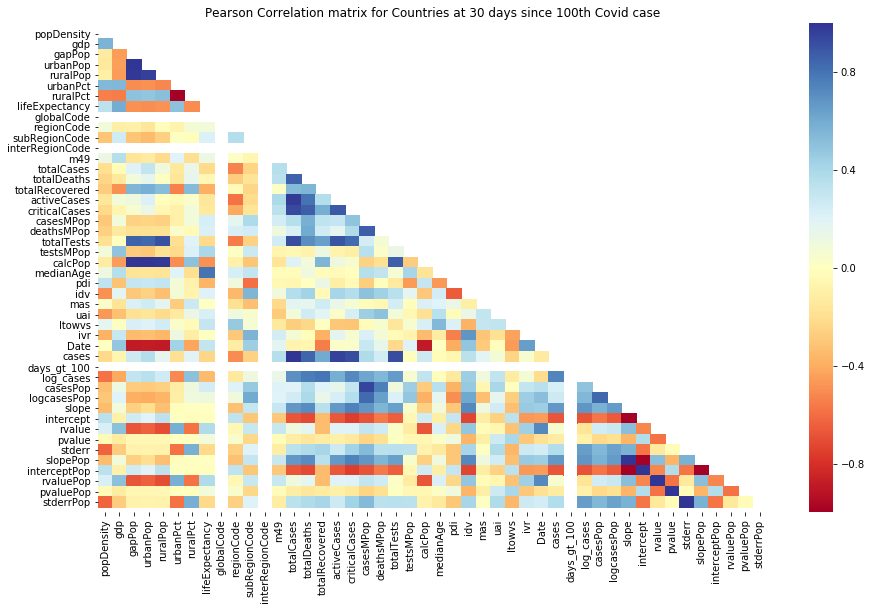

In [156]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr35)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr35,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

In [157]:
corr35.to_csv('corrcases35.csv')

## Create subset of Countries that have reached 40 days > 100 cases

In [158]:
cases40 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 40).sum())>0]

In [159]:
cases40group = cases40.groupby('Code')

In [160]:
cases40slopes = (cases40group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))
casesPop40slopes = (cases40group.apply(lambda x: pd.Series(linregress(x['Date'],x['logcasesPop'])))\
        .rename(columns={
        0: 'slopePop',
        1: 'interceptPop',
        2: 'rvaluePop',
        3: 'pvaluePop',
        4: 'stderrPop'
    }))

In [161]:
merged40 = merged_data[merged_data.days_gt_100 == 40]

In [162]:
mergedcases40 = pd.merge(merged40, cases40slopes, on=["Code"])
mergedcases40 = pd.merge(mergedcases40, casesPop40slopes, on=["Code"])

In [163]:
# Export CSV
mergedcases40.to_csv('cases40.csv')  

In [164]:
corr40 = mergedcases40.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

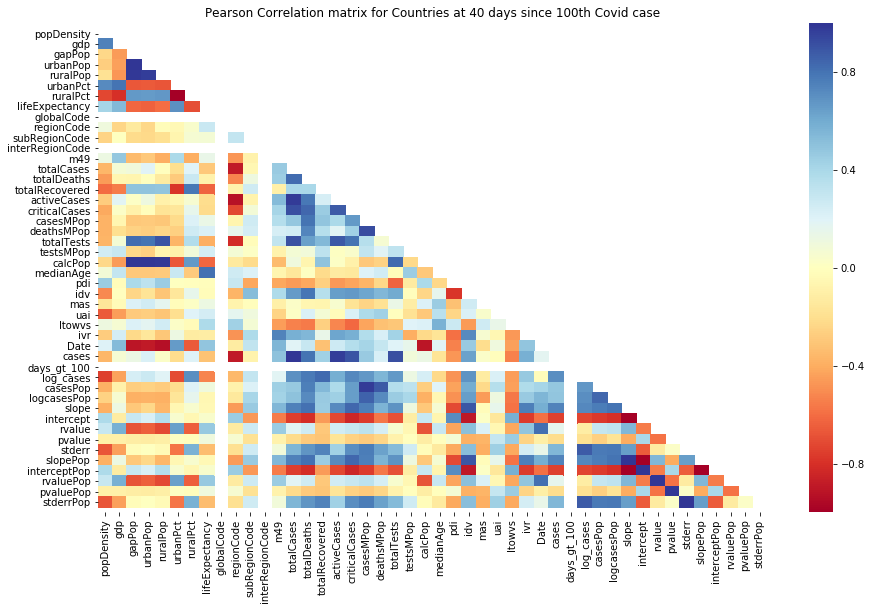

In [165]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr40)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr40,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

In [166]:
corr40.to_csv('corrcases40.csv')

### Concatonate the dataframes back together into one dataframe

In [167]:
# Concatonate all the dataframes 
cases_df = pd.concat([mergedcases40, mergedcases35, mergedcases30, mergedcases20, mergedcases10, mergedcases5])

In [168]:
cases_df.head()

,Entity,Code,popDensity,gdp,gapPop,urbanPop,ruralPop,urbanPct,ruralPct,lifeExpectancy,...,slope,intercept,rvalue,pvalue,stderr,slopePop,interceptPop,rvaluePop,pvaluePop,stderrPop
0,China,CHN,146.057646,13569.891527,1.397029e+09,761027100,610192900,55.500,44.500000,76.092000,...,4.948030e-07,-772.810983,0.719859,2.723236e-15,5.144821e-08,4.948030e-07,-793.902067,0.719859,2.723236e-15,5.144821e-08
1,France,FRA,121.619057,37766.374112,6.445720e+07,53044946,13548420,79.655,20.344999,82.273171,...,1.746799e-06,-2759.408335,0.961210,3.030031e-26,7.556464e-08,1.746799e-06,-2777.402557,0.961210,3.030031e-26,7.556464e-08
2,Germany,DEU,234.153658,43937.947132,8.170779e+07,63062064,18624547,77.200,22.799999,80.641463,...,1.878422e-06,-2967.888365,0.960534,4.400650e-26,8.200702e-08,1.878422e-06,-2986.132328,0.960534,4.400650e-26,8.200702e-08
3,Hong Kong,HKG,6944.095238,53591.835820,7.245701e+06,7291300,0,100.000,0.000000,84.278049,...,7.774401e-07,-1226.425603,0.979942,4.718679e-31,2.439556e-08,7.774401e-07,-1242.253071,0.979942,4.718679e-31,2.439556e-08
4,Iran,IRN,48.724482,16500.900512,7.936049e+07,58217266,21143221,73.358,26.642000,75.730000,...,1.190191e-06,-1876.707683,0.920891,7.385381e-21,7.348903e-08,1.190191e-06,-1894.954442,0.920891,7.385381e-21,7.348903e-08


In [169]:
cases_df.to_csv('cases_df.csv')

In [185]:
cases_df.columns

Index(['Entity', 'Code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'globalCode', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionCode', 'interRegionName', 'country', 'm49', 'ldc', 'lldc',
       'sids', 'development', 'countryWom', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'medianAge', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'Date', 'cases', 'days_gt_100',
       'log_cases', 'casesPop', 'logcasesPop', 'slope', 'intercept', 'rvalue',
       'pvalue', 'stderr', 'slopePop', 'interceptPop', 'rvaluePop',
       'pvaluePop', 'stderrPop'],
      dtype='object')

In [187]:
cases_df.head()
multi_slope = cases_df.set_index(['globalName','regionName','subRegionName','country'])
multi_slope = multi_slope.sort_index()
print(multi_slope.shape)
multi_slope.head()

(348, 54)


Entity Code  popDensity  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Algeria  Algeria  DZA   16.740504   
                                      Egypt      Egypt  EGY   94.206813   
                                      Egypt      Egypt  EGY   94.206813   

                                                        gdp      gapPop  \
globalName regionName subRegionName   country                             
World      Africa     Northern Africa Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Algeria  13724.723853  39871528.0   
                                      Egypt    10095.610168  93778172.0   
                                      Egypt    10095.610168  93778172.0   

                                               urbanPop  ruralPop  urbanPct  \
globalName regionName subRegionName   country                                 
World      Africa     Northern Africa Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Algeria  28248180  11623348    70.848   
                                      Egypt    40122991  53655181    42.785   
                                      Egypt    40122991  53655181    42.785   

                                               ruralPct  lifeExpectancy  ...  \
globalName regionName subRegionName   country                            ...   
World      Africa     Northern Africa Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Algeria    29.152          75.860  ...   
                                      Egypt      57.215          71.304  ...   
                                      Egypt      57.215          71.304  ...   

                                                  slope    intercept  \
globalName regionName subRegionName   country                          
World      Africa     Northern Africa Algeria  0.000001 -2212.579335   
                                      Algeria  0.000001 -2212.579335   
                                      Algeria  0.000001 -2212.579335   
                                      Egypt    0.000001 -1762.030791   
                                      Egypt    0.000001 -1762.030791   

                                                 rvalue        pvalue  \
globalName regionName subRegionName   country                           
World      Africa     Northern Africa Algeria  0.967676  1.194346e-14   
                                      Algeria  0.967676  1.194346e-14   
                                      Algeria  0.967676  1.194346e-14   
                                      Egypt    0.994353  8.283978e-30   
                                      Egypt    0.994353  8.283978e-30   

                                                     stderr  slopePop  \
globalName regionName subRegionName   country                           
World      Africa     Northern Africa Algeria  7.775270e-08  0.000001   
                                      Algeria  7.775270e-08  0.000001   
                                      Algeria  7.775270e-08  0.000001   
                                      Egypt    2.210442e-08  0.000001   
                                      Egypt    2.210442e-08  0.000001   

                                              interceptPop rvaluePop  \
globalName regionName subRegionName   country                          
World      Africa     Northern Africa Algeria -2230.180889  0.967676   
                                      Algeria -2230.180889  0.967676   
                                      Algeria -2230.180889  0.96

### Function to easily do a panel of scatterplots easily

In [170]:
def makePanelScatterplot(data_df, x_data,y_data,color_col,split_col):
    x_label = x_data
    y_label = y_data
    ylim_min = data_df[y_data].min()*1.05
    ylim_max = data_df[y_data].max()*1.05
    xlim_min = data_df[x_data].min()*1.05
    xlim_max = data_df[x_data].max()*1.05

    g = sns.lmplot(x=x_data, y=y_data, data=data_df,\
           hue=color_col, col=split_col,col_wrap=3)

        
    g = (g.set_axis_labels(x_label, y_label)
          .set(ylim=(ylim_min, ylim_max),xlim=(xlim_min, xlim_max))
          .fig.subplots_adjust(wspace=.02))

# Slope of # Covid Cases vs. Power-Distance (PDI) of Culture

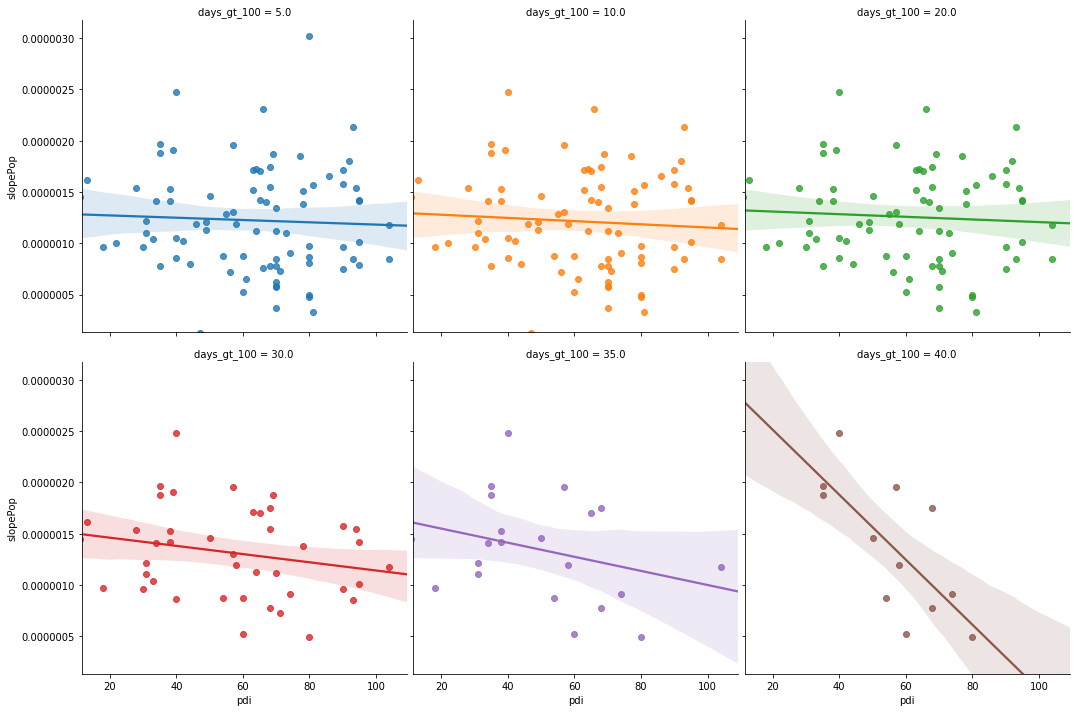

In [193]:
makePanelScatterplot(cases_df,"pdi","slopePop","days_gt_100","days_gt_100")

# Slope of # Covid Cases vs. Individualism/Collectivism of Culture

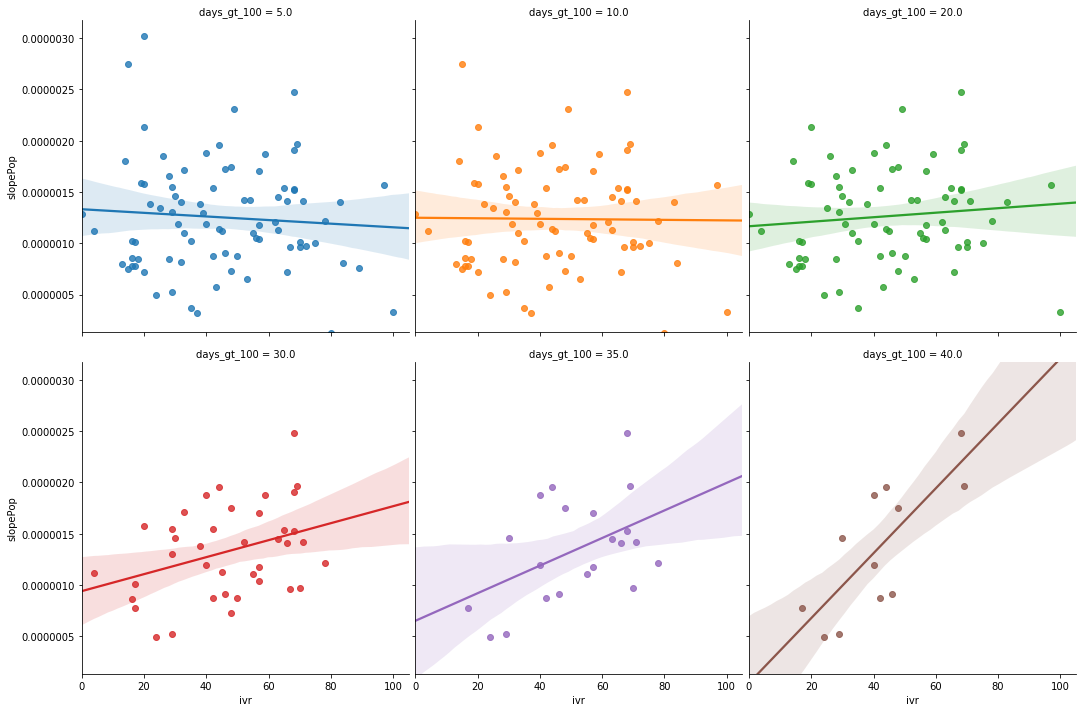

In [194]:
makePanelScatterplot(cases_df,"ivr","slopePop","days_gt_100","days_gt_100")

# Slope of # Covid Cases vs. Indulgence (IVR) of Culture

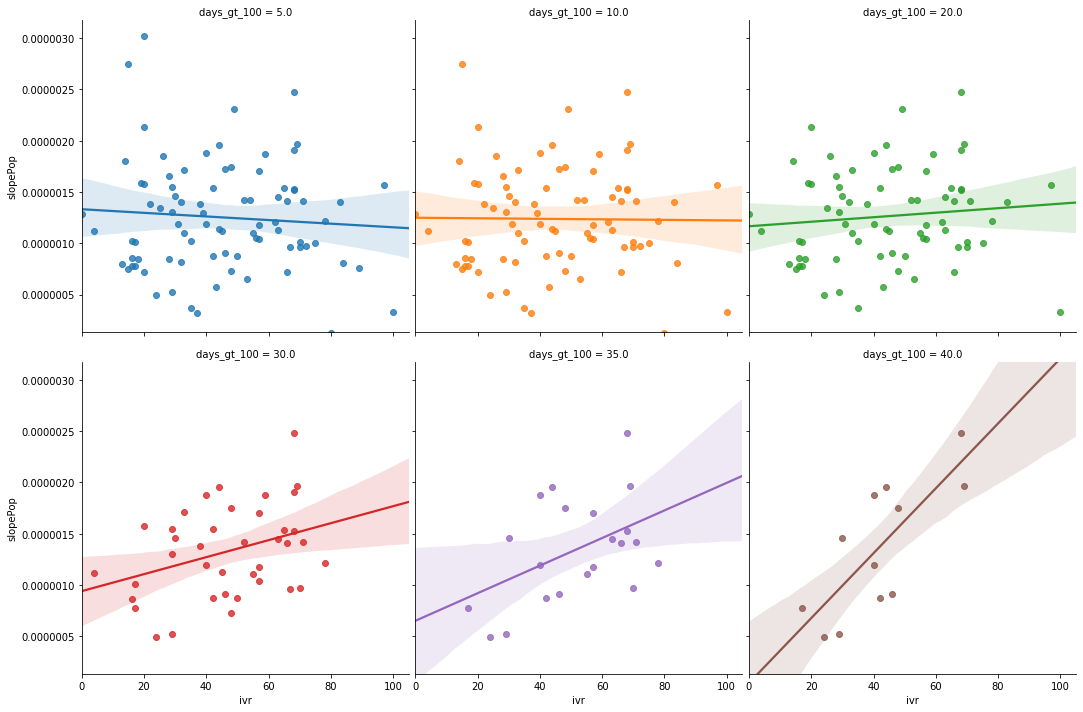

In [195]:
makePanelScatterplot(cases_df,"ivr","slopePop","days_gt_100","days_gt_100")

# Slope of # Covid Cases vs. Long-term Orientation (LTOWVS) of Culture

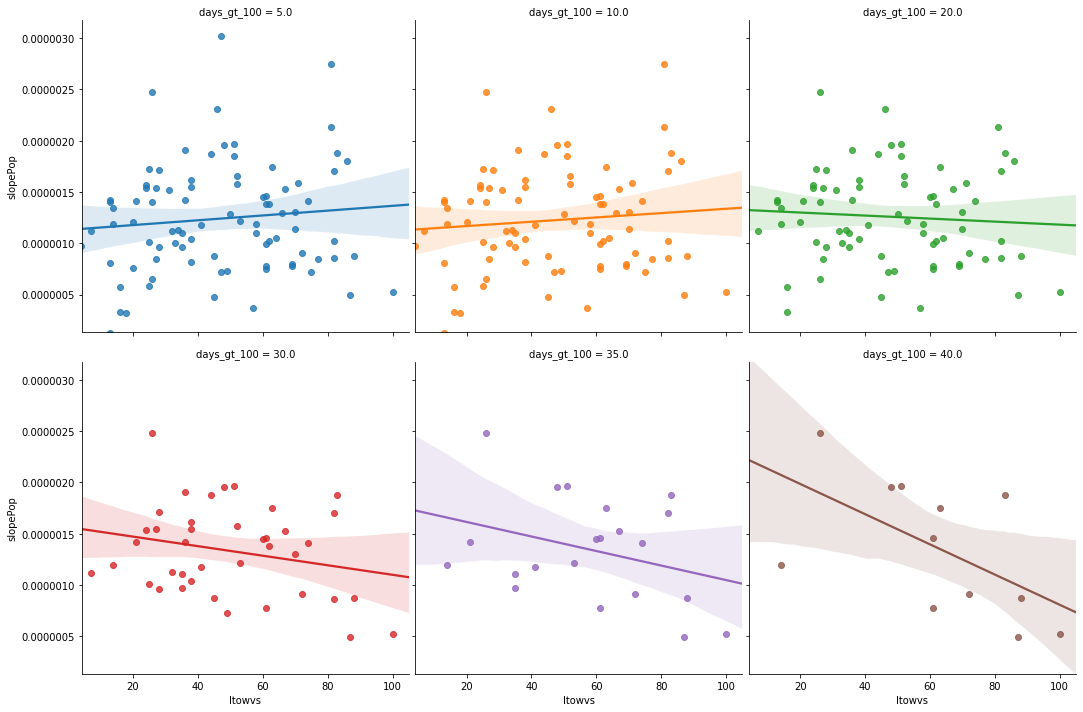

In [196]:
makePanelScatterplot(cases_df,"ltowvs","slopePop","days_gt_100","days_gt_100")

# Slope of # Covid Cases vs. Masculine/Feminine (MAS) of Culture

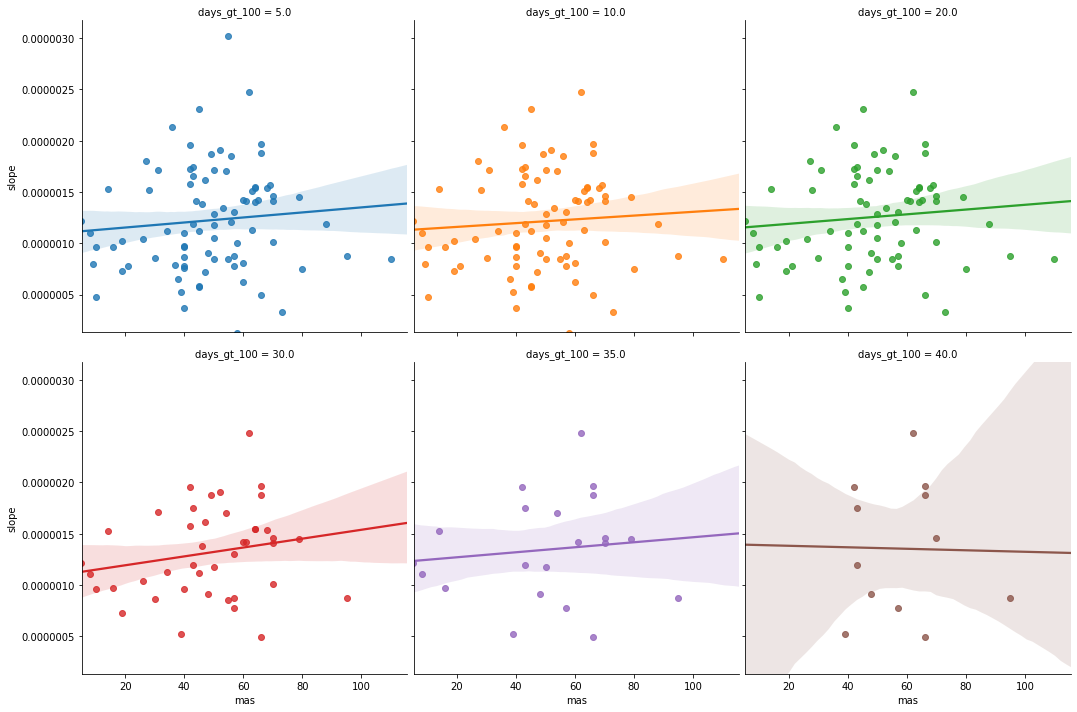

In [175]:
makePanelScatterplot(cases_df,"mas","slope","days_gt_100","days_gt_100")

# Slope of # Covid Cases vs. Uncertainty Avoidance (UAI) of Culture

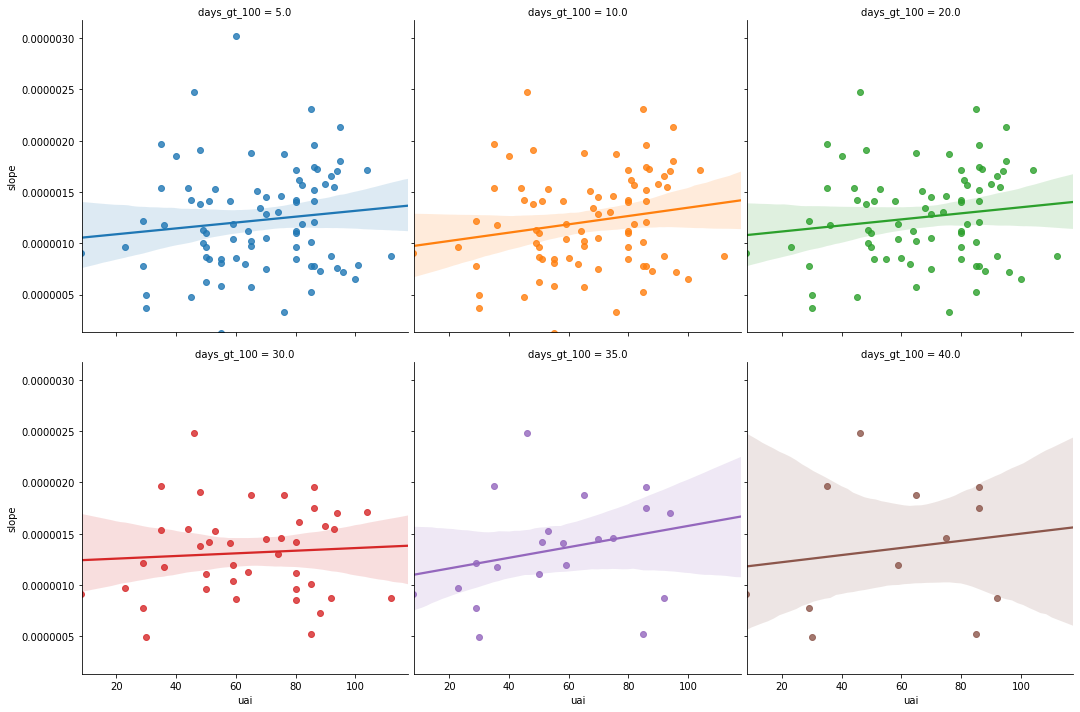

In [176]:
makePanelScatterplot(cases_df,"uai","slope","days_gt_100","days_gt_100")

In [177]:
cases_df.columns

Index(['Entity', 'Code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'globalCode', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionCode', 'interRegionName', 'country', 'm49', 'ldc', 'lldc',
       'sids', 'development', 'countryWom', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'medianAge', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'Date', 'cases', 'days_gt_100',
       'log_cases', 'casesPop', 'logcasesPop', 'slope', 'intercept', 'rvalue',
       'pvalue', 'stderr', 'slopePop', 'interceptPop', 'rvaluePop',
       'pvaluePop', 'stderrPop'],
      dtype='object')

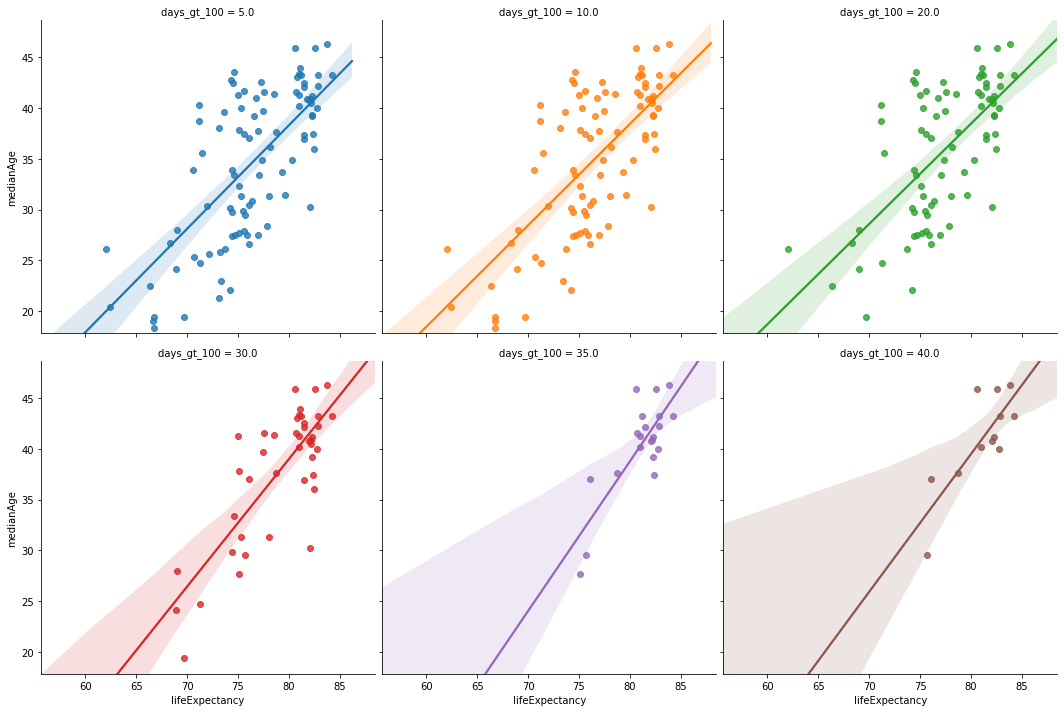

In [178]:
makePanelScatterplot(cases_df,"lifeExpectancy","medianAge","days_gt_100","days_gt_100")

# Change is

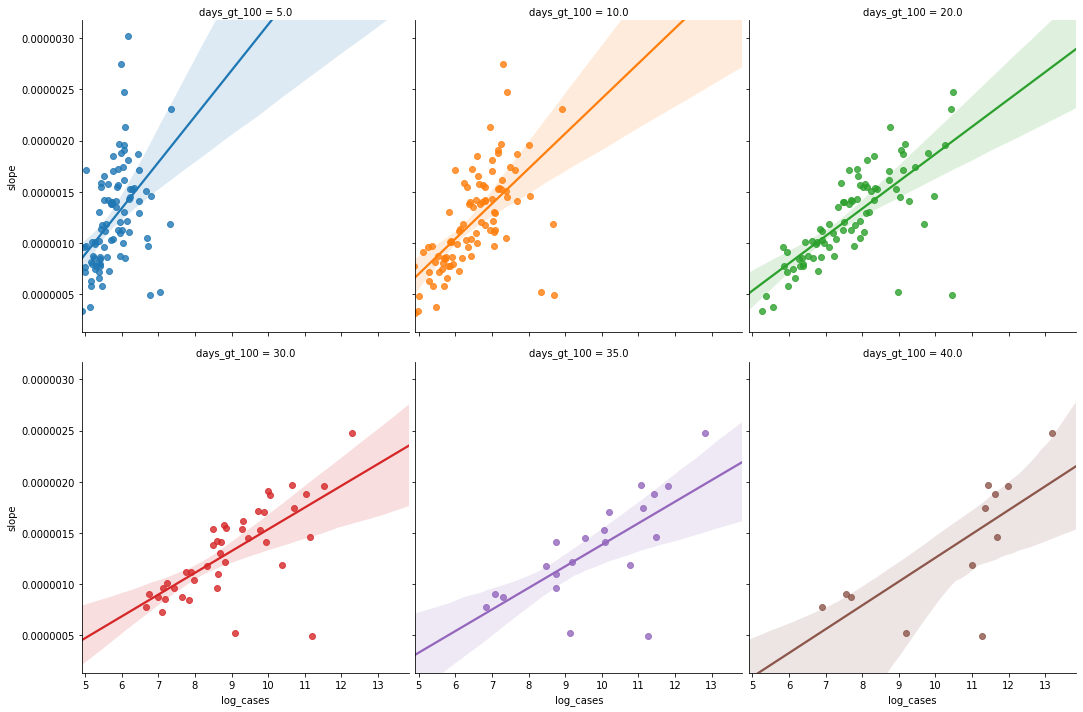

In [179]:
makePanelScatterplot(cases_df,"log_cases","slope","days_gt_100","days_gt_100")

In [180]:
cases_df.columns

Index(['Entity', 'Code', 'popDensity', 'gdp', 'gapPop', 'urbanPop', 'ruralPop',
       'urbanPct', 'ruralPct', 'lifeExpectancy', 'globalCode', 'globalName',
       'regionCode', 'regionName', 'subRegionCode', 'subRegionName',
       'interRegionCode', 'interRegionName', 'country', 'm49', 'ldc', 'lldc',
       'sids', 'development', 'countryWom', 'totalCases', 'totalDeaths',
       'totalRecovered', 'activeCases', 'criticalCases', 'casesMPop',
       'deathsMPop', 'totalTests', 'testsMPop', 'calcPop', 'medianAge', 'pdi',
       'idv', 'mas', 'uai', 'ltowvs', 'ivr', 'Date', 'cases', 'days_gt_100',
       'log_cases', 'casesPop', 'logcasesPop', 'slope', 'intercept', 'rvalue',
       'pvalue', 'stderr', 'slopePop', 'interceptPop', 'rvaluePop',
       'pvaluePop', 'stderrPop'],
      dtype='object')

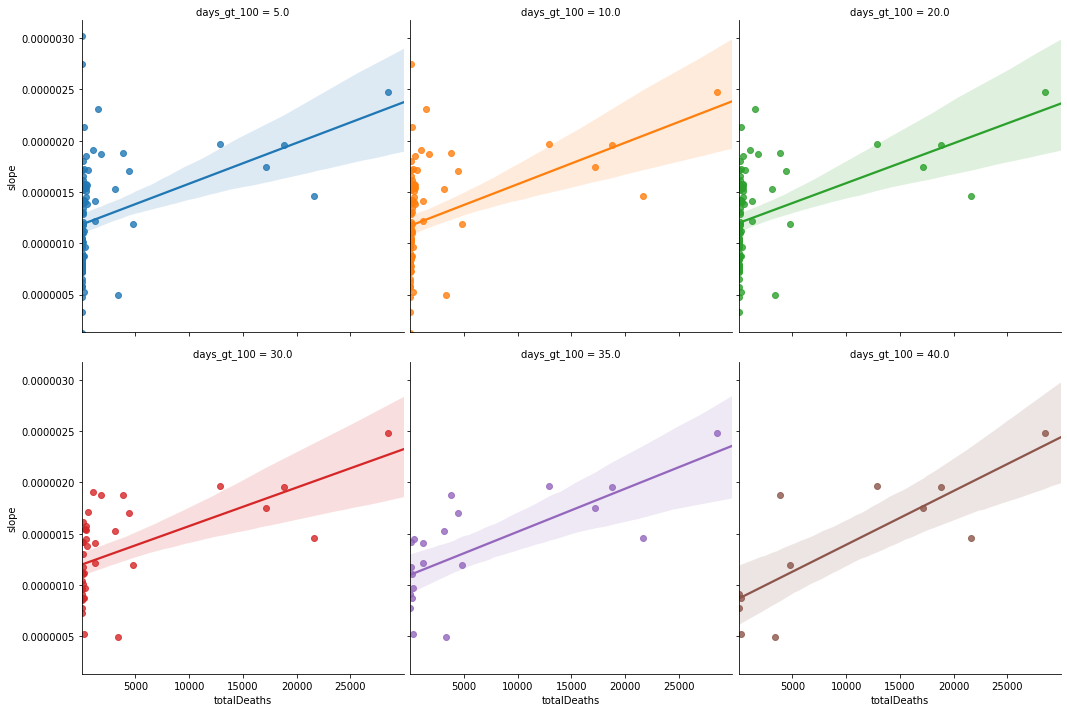

In [181]:
makePanelScatterplot(cases_df,"totalDeaths","slope","days_gt_100","days_gt_100")

In [182]:
def olsRegressionAnalysis (df,df_name,dep_col,ind_col):
    stat_dep_col = dep_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_ind_col = ind_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_col_list = [stat_dep_col,stat_ind_col]
    #print(f'stat_dep_col: {stat_dep_col}, stat_ind_col: {stat_ind_col}')
    col_list = [dep_col,ind_col]

    col_dict = {col_list[i]: stat_col_list[i] for i in range(len(col_list))} 
    #print(col_dict)
    stat_df = df[col_list].dropna()
    stat_df.rename(columns=col_dict,inplace=True)
    print(f'\u001b[34m{dep_col}\u001b[0m fitted against \u001b[34m{ind_col}\u001b[0m \
    using \x1b[31m{df_name}\x1b[0m dataframe:\n')
    print(f'We have {stat_df.shape[0]} rows left after dropping Null values\n')
    model_string = stat_dep_col + " ~ " + stat_ind_col
    all_model = ols(model_string, data=stat_df).fit()
    print(all_model.summary())

In [183]:
cases_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 96
Data columns (total 58 columns):
Entity             348 non-null object
Code               348 non-null object
popDensity         348 non-null float64
gdp                345 non-null float64
gapPop             348 non-null float64
urbanPop           348 non-null int64
ruralPop           348 non-null int64
urbanPct           348 non-null float64
ruralPct           348 non-null float64
lifeExpectancy     348 non-null float64
globalCode         348 non-null int64
globalName         348 non-null object
regionCode         348 non-null int64
regionName         348 non-null object
subRegionCode      348 non-null int64
subRegionName      348 non-null object
interRegionCode    59 non-null float64
interRegionName    55 non-null object
country            348 non-null object
m49                348 non-null int64
ldc                8 non-null object
lldc               15 non-null object
sids               11 non-null object
deve

In [ ]:
jupyter nbconvert merge_data_modified.ipynb --to html --output covidCulture.html

In [ ]:
#olsRegressionAnalysis(cases40,"log_cases","slope","Code")

In [ ]:

#merged_data['slope'] = merged_data.groupby('Code').diff()(lambda v: linregress(v.Date, v.cases)[0])
#merged_data['slope'] = (merged_data.groupby('Code')['cases'].apply(lambda x: x.shift().expanding().mean()))
#merged_data['slope'] = (merged_data.groupby('Code')['Date','cases'].apply(lambda x,y : x.shift().expanding().apply(lambda v: linregress([0], [1])[0])))